In [1]:
# predict_on_training_and_save_metrics.py
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from sqlalchemy import create_engine, text
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from imblearn.over_sampling import RandomOverSampler

# CONFIG
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = (
    f"postgresql://{db_config['user']}:{db_config['password']}@"
    f"{db_config['host']}:{db_config['port']}/{db_config['database']}"
)
engine = create_engine(connection_string)

model_filename = "gbm_model.pkl"
encoders_filename = "label_encoders_gbm.pkl"
features_filename = "model_features_gbm.pkl"

# The same column list you used previously
selected_columns = ['rto_risk_factor', 'ncb % previous year', 'state_risk_score', 'retention_rate_pct', 'total od premium_max', 'applicable discount with ncb', 
                    'policy_wise_purchase', 'manufacturer_risk_rate', 'days_between_renewals', 'retention_streak', 'total od premium_mean', 'total od premium', 
                    'firstpolicyyear', 'lag_1_tp_premium', 'total od premium_min', 'avg_premium_hist', 'lag_1_ncb', 'age', 'total tp premium_max', 'total tp premium_mean', 
                    'total tp premium', 'total tp premium_min', 'lag_1_premium', 'previous_year_premium_ratio', 'total premium payable', 'total_revenue', 'gst', 
                    'fuel_type_risk_factor', 'lag_1_od_premium', 'Customer_APV', 'segment_risk_score', 'vehicle idv', 'Policy Tenure', 'Number of claims', 'approved', 
                    'claim_approval_rate', 'Customer Tenure', 'before gst add-on gwp', 'od_tp_ratio', 'add_on_adoption', 'CLV', 'idv_premium_ratio', 'Customer_APF', 
                    'days_gap_prev_end_to_curr_start', 'customerid', 'Claim Happaned/Not', 'Cleaned Branch Name 2', 'Cleaned Chassis Number', 'Cleaned Engine Number', 
                    'Cleaned Reg no', 'Cleaned State2', 'Cleaned Zone 2', 'biztype', 'corrected_name', 'make_clean', 'model_clean', 'product name', 'policy no', 
                    'policy end date', 'policy start date', 'decline', 'tie up', 'variant', 'Policy Status']

# LOAD SAVED MODEL & ENCODERS
model = joblib.load(model_filename)
label_encoders = joblib.load(encoders_filename)   
features = joblib.load(features_filename)         

# LOAD RAW DATA (same table)
query = 'SELECT * FROM public.policydata_with_fb_cc_pc_newfea_opti_correct;'
df = pd.read_sql(query, con=engine)
df = df[selected_columns].copy()

# SAME PREPROCESSING AS TRAINING
# Convert date column(s)
df['policy end date'] = pd.to_datetime(df['policy end date'], errors='coerce')
df['policy start date'] = pd.to_datetime(df['policy start date'], errors='coerce')

# Filter the main dataset to the same subset training used originally:
df = df[df['Policy Status'].isin(['Renewed', 'Not Renewed'])].copy()

# Map Policy Status to binary exactly as training did
df['Policy Status'] = df['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

# Fill missing values exactly as training did
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna('none')
    else:
        df[column] = df[column].fillna(0)

# Create date-derived features (YEAR, MONTH, DAY) and drop original date cols
date_cols = ['policy start date', 'policy end date']
new_date_cols = {}
for col in date_cols:
    new_date_cols[f'{col}_YEAR'] = df[col].dt.year
    new_date_cols[f'{col}_MONTH'] = df[col].dt.month
    new_date_cols[f'{col}_DAY'] = df[col].dt.day

df = pd.concat([df, pd.DataFrame(new_date_cols)], axis=1)
df = df.drop(columns=date_cols)

# Separate features/target
X = df[[c for c in df.columns if c != 'Policy Status']].copy()
y = df['Policy Status'].copy()

# APPLY THE SAME OVERSAMPLING USED IN TRAINING
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# ENCODE CATEGORICALS USING SAVED ENCODERS
X_enc = X_res.copy()

for column in X_enc.columns:
    if column in label_encoders:
        
        encoder = label_encoders[column]

        # Build Version-1 mapping using encoder classes
        mapping_dict = {label: i for i, label in enumerate(encoder.classes_)}

        # Version-1 behavior
        next_unique_value = [max(mapping_dict.values()) + 1]

        # Dynamic encoder (Version-1 style)
        def encode_value(value):
            key = str(value)  
            if key in mapping_dict:
                return mapping_dict[key]
            else:
                mapping_dict[key] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[key]

        X_enc[column] = X_enc[column].astype(str).apply(encode_value)


# For any remaining object dtype columns that DID NOT have saved encoders, convert to strings
# and map to integers to ensure the model receives numeric data.
for col in X_enc.columns:
    if X_enc[col].dtype == 'object':
        X_enc[col] = X_enc[col].astype(str).factorize()[0]

# Ensure column order matches features list (and handle missing features gracefully)
missing_feats = [f for f in features if f not in X_enc.columns]
if missing_feats:
    print("Warning: missing features added with zeros:", missing_feats)
    for feat in missing_feats:
        X_enc[feat] = 0

X_enc = X_enc[features]  

# PREDICT
y_pred = model.predict(X_enc)
y_pred_proba = model.predict_proba(X_enc)[:, 1]

# clip probabilities to avoid numerical issues in log_loss
y_pred_proba = np.clip(y_pred_proba, 1e-6, 1 - 1e-6)

# ==================== ROC CURVE CALCULATION ====================
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_res, y_pred_proba)

# # Print ROC curve points to console
# print("\n" + "="*70)
# print("ROC CURVE DATA POINTS")
# print("="*70)
# print(f"{'False Positive Rate':<25} | {'True Positive Rate':<25} | {'Threshold':<15}")
# print("-" * 70)
# for i in range(len(fpr)):
#     print(f"{fpr[i]:<25.6f} | {tpr[i]:<25.6f} | {thresholds[i]:<15.6f}")
# print("="*70 + "\n")

# Create ROC curve dataframe
roc_df = pd.DataFrame({
    'run_id': datetime.utcnow().strftime('%Y%m%d_%H%M%S'),
    'model_name': 'gbm_model',
    'run_timestamp_utc': datetime.utcnow(),
    'dataset': 'training_oversampled',
    'point_index': range(len(fpr)),
    'false_positive_rate': fpr,
    'true_positive_rate': tpr,
    'threshold': thresholds
})

# Save ROC curve to CSV
roc_csv_file = 'roc_curve_points.csv'
roc_df.to_csv(roc_csv_file, index=False)
print(f"ROC curve points saved to CSV: {roc_csv_file}")

# Save ROC curve to PostgreSQL table
roc_table_name = 'model_roc_curve_data'
with engine.begin() as conn:
    create_roc_table_sql = f"""
    CREATE TABLE IF NOT EXISTS {roc_table_name} (
        run_id TEXT,
        model_name TEXT,
        run_timestamp_utc TIMESTAMP,
        dataset TEXT,
        point_index INTEGER,
        false_positive_rate DOUBLE PRECISION,
        true_positive_rate DOUBLE PRECISION,
        threshold DOUBLE PRECISION
    );
    """
    conn.execute(text(create_roc_table_sql))

# Append ROC curve data to table
roc_df.to_sql(roc_table_name, engine, if_exists="append", index=False, chunksize=10000)
print(f"ROC curve data saved to PostgreSQL table: {roc_table_name}")
print(f"Total ROC points saved: {len(roc_df)}\n")

# METRICS
train_accuracy = accuracy_score(y_res, y_pred)
train_log_loss = log_loss(y_res, y_pred_proba)
train_roc_auc = roc_auc_score(y_res, y_pred_proba)

train_report = classification_report(y_res, y_pred, zero_division=0)
conf_matrix_train = confusion_matrix(y_res, y_pred)

# Class-wise accuracy (guard for shapes)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum() if conf_matrix_train.shape[0] > 0 and conf_matrix_train[0].sum() > 0 else np.nan
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum() if conf_matrix_train.shape[0] > 1 and conf_matrix_train[1].sum() > 0 else np.nan

# Per-class precision, recall, f1
report_dict = classification_report(y_res, y_pred, output_dict=True, zero_division=0)

precision_0 = report_dict.get("0", {}).get("precision", np.nan)
recall_0    = report_dict.get("0", {}).get("recall", np.nan)
f1_0        = report_dict.get("0", {}).get("f1-score", np.nan)

precision_1 = report_dict.get("1", {}).get("precision", np.nan)
recall_1    = report_dict.get("1", {}).get("recall", np.nan)
f1_1        = report_dict.get("1", {}).get("f1-score", np.nan)

# Macro avg
precision_macro = report_dict.get("macro avg", {}).get("precision", np.nan)
recall_macro    = report_dict.get("macro avg", {}).get("recall", np.nan)
f1_macro        = report_dict.get("macro avg", {}).get("f1-score", np.nan)

# Extract confusion matrix values
tn = int(conf_matrix_train[0, 0]) if conf_matrix_train.shape[0] > 0 else 0
fp = int(conf_matrix_train[0, 1]) if conf_matrix_train.shape[0] > 0 and conf_matrix_train.shape[1] > 1 else 0
fn = int(conf_matrix_train[1, 0]) if conf_matrix_train.shape[0] > 1 else 0
tp = int(conf_matrix_train[1, 1]) if conf_matrix_train.shape[0] > 1 and conf_matrix_train.shape[1] > 1 else 0


# Compose metrics row (use the train_* variables)
metrics_row = {
    'run_id': datetime.utcnow().strftime('%Y%m%d_%H%M%S'),
    'model_name': 'gbm_model',
    'run_timestamp_utc': datetime.utcnow(),
    'dataset': 'training_oversampled',
    'n_samples': int(len(y_res)),
    'accuracy': float(train_accuracy),
    'log_loss': float(train_log_loss),
    'roc_auc': float(train_roc_auc) if not np.isnan(train_roc_auc) else None,
    'class_0_accuracy': float(class_0_accuracy_train) if not np.isnan(class_0_accuracy_train) else None,
    'class_1_accuracy': float(class_1_accuracy_train) if not np.isnan(class_1_accuracy_train) else None,

    # Confusion Matrix Values
    'true_negative': tn,
    'false_positive': fp,
    'false_negative': fn,
    'true_positive': tp,

    # Per-class
    'precision_0': float(precision_0) if not np.isnan(precision_0) else None,
    'recall_0': float(recall_0) if not np.isnan(recall_0) else None,
    'f1_0': float(f1_0) if not np.isnan(f1_0) else None,

    'precision_1': float(precision_1) if not np.isnan(precision_1) else None,
    'recall_1': float(recall_1) if not np.isnan(recall_1) else None,
    'f1_1': float(f1_1) if not np.isnan(f1_1) else None,

    # Macro
    'precision_macro': float(precision_macro) if not np.isnan(precision_macro) else None,
    'recall_macro': float(recall_macro) if not np.isnan(recall_macro) else None,
    'f1_macro': float(f1_macro) if not np.isnan(f1_macro) else None
}

metrics_df = pd.DataFrame([metrics_row])

# SAVE METRICS TO POSTGRES 
table_name = 'model_performance_metrics'
with engine.begin() as conn:
    create_sql = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        run_id TEXT,
        model_name TEXT,
        run_timestamp_utc TIMESTAMP,
        dataset TEXT,
        n_samples INTEGER,
        accuracy DOUBLE PRECISION,
        log_loss DOUBLE PRECISION,
        roc_auc DOUBLE PRECISION,
        class_0_accuracy DOUBLE PRECISION,
        class_1_accuracy DOUBLE PRECISION,
        true_negative INTEGER,
        false_positive INTEGER,
        false_negative INTEGER,
        true_positive INTEGER,
        precision_0 DOUBLE PRECISION,
        recall_0 DOUBLE PRECISION,
        f1_0 DOUBLE PRECISION,
        precision_1 DOUBLE PRECISION,
        recall_1 DOUBLE PRECISION,
        f1_1 DOUBLE PRECISION,
        precision_macro DOUBLE PRECISION,
        recall_macro DOUBLE PRECISION,
        f1_macro DOUBLE PRECISION
    );
    """
    conn.execute(text(create_sql))

# append the metrics row
metrics_df.to_sql(table_name, engine, if_exists="append", index=False, chunksize=10000)

# Save predictions CSV for inspection
pred_out = X_res.copy()
pred_out['actual'] = y_res
pred_out['predicted'] = y_pred
pred_out['predicted_proba'] = y_pred_proba
pred_file = "training_set_predictions_with_probs.csv"
pred_out.to_csv(pred_file, index=False)

# PRINT SUMMARY
print("Saved metrics to Postgres table:", table_name)
print(metrics_df.to_string(index=False))
print(f"Saved full predictions CSV to: {pred_file}")

# close engine
engine.dispose()

ROC curve points saved to CSV: roc_curve_points.csv
ROC curve data saved to PostgreSQL table: model_roc_curve_data
Total ROC points saved: 610945

Saved metrics to Postgres table: model_performance_metrics
         run_id model_name          run_timestamp_utc              dataset  n_samples  accuracy  log_loss  roc_auc  class_0_accuracy  class_1_accuracy  true_negative  false_positive  false_negative  true_positive  precision_0  recall_0     f1_0  precision_1  recall_1     f1_1  precision_macro  recall_macro  f1_macro
20251205_122504  gbm_model 2025-12-05 12:25:04.514326 training_oversampled    1895276  0.855527  0.342288 0.929137          0.848353            0.8627         803932          143706          130111         817527     0.860701  0.848353 0.854483     0.850498    0.8627 0.856556           0.8556      0.855527  0.855519
Saved full predictions CSV to: training_set_predictions_with_probs.csv


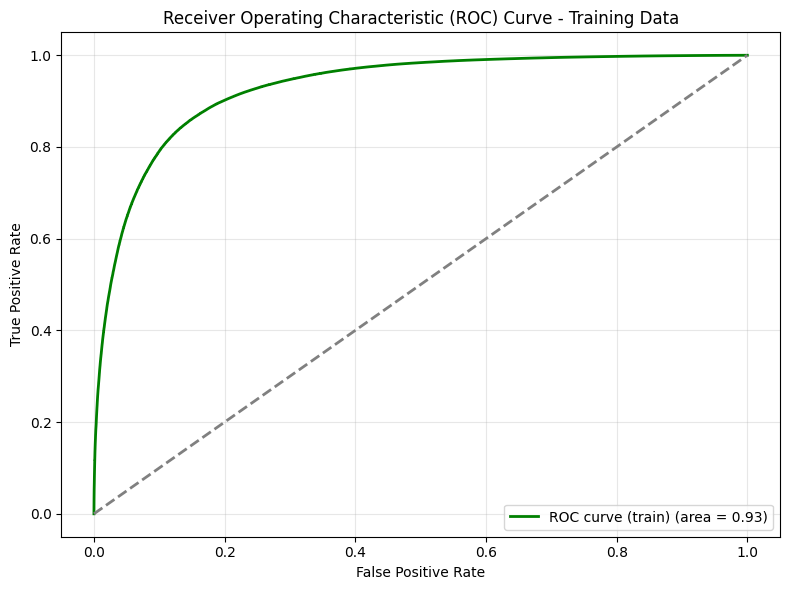

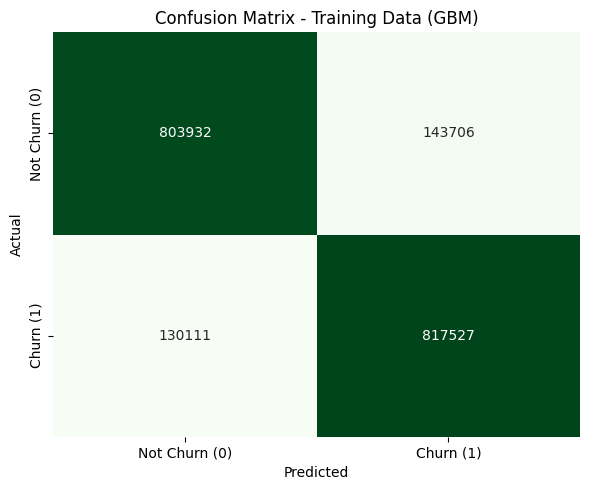

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

# --- Ensure ROC values exist (compute if not present) ---
# Uses training variables from your run: y_res (true), y_pred_proba (predicted probs), conf_matrix_train (confusion matrix)
fpr_train, tpr_train, _ = roc_curve(y_res, y_pred_proba)
train_roc_auc = roc_auc_score(y_res, y_pred_proba)

# --- Plot ROC curve for training data (green style) ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='green', lw=2,
         label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot Confusion Matrix - Training Data (green heatmap) ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Churn (0)', 'Churn (1)'],
            yticklabels=['Not Churn (0)', 'Churn (1)'],
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data (GBM)')
plt.tight_layout()
plt.show()